---
title: "Лабораторна робота № 2 (Суміщення зображень на основі використання дескрипторів)"
author: "Григораш Назарій"
fig-align: center
---

In [1]:
# pip install opencv-contrib-python

import cv2
import numpy as np
import matplotlib.pyplot as plt

from cv2 import DMatch

In [2]:
image_path = 'images/img1'

<h1> SURF implementation

In [3]:
def detect_surf(image, threshold=1000):
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    keypoints = []

    num_octaves = 4
    num_scales = 5
    k = 2 ** (1 / num_scales)
    initial_sigma = 1.6

    for octave in range(num_octaves):
        sigma = initial_sigma

        for scale in range(num_scales):
            factor = (2 ** octave) * k ** scale
            scale_dx = cv2.resize(dx, None, fx=factor, fy=factor)
            scale_dy = cv2.resize(dy, None, fx=factor, fy=factor)
            hessian_xx = cv2.GaussianBlur(scale_dx * scale_dx, (9, 9), sigma)
            hessian_xy = cv2.GaussianBlur(scale_dx * scale_dy, (9, 9), sigma)
            hessian_yy = cv2.GaussianBlur(scale_dy * scale_dy, (9, 9), sigma)
            harris_response = (hessian_xx * hessian_yy - hessian_xy ** 2) - 0.04 * ((hessian_xx + hessian_yy) ** 2)
            local_maxima = (harris_response == cv2.dilate(harris_response, np.ones((3, 3))))
            keypoints.extend(zip(*np.where(local_maxima & (harris_response > threshold))))

            sigma *= k

    return list(map(lambda kp: cv2.KeyPoint(float(kp[0]), float(kp[1]), 1), keypoints))

././././././.

In [4]:
def compute_brief_descriptors(image, keypoints):
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    keypoints, descriptors = brief.compute(image, keypoints)
    return keypoints, descriptors

In [5]:
def distort_image(image, angle=40, dx=25, dy=25):
    rows, cols = image.shape[:2]
    M_rot = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    M_trans = np.float32([[1, 0, dx], [0, 1, dy]])
    rotated = cv2.warpAffine(image, M_rot, (cols, rows))
    translated = cv2.warpAffine(rotated, M_trans, (cols, rows))

    return translated

In [6]:
def create_descriptors(image1, image2):    
    kp1 = detect_surf(image1)
    kp1, des1 = compute_brief_descriptors(image1, kp1)
    
    kp2 = detect_surf(image2)
    kp2, des2 = compute_brief_descriptors(image2, kp2)

    return kp1, des1, kp2, des2

In [7]:
def matcher(des1, des2, threshold):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    good_matches = [m for m in matches if m.distance < threshold]

    return good_matches

In [29]:
def validate_matches(image1, kp1, image2, kp2, matches, file_name):
    matched_image = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)
    plt.imshow(matched_image, cmap='gray')
    plt.imsave(file_name, matched_image)

In [9]:
original_image = cv2.imread(image_path + '.png', cv2.IMREAD_GRAYSCALE)

In [12]:
distorted_image = distort_image(original_image, angle=22, dx=7, dy=7)

In [13]:
cv2.imwrite(image_path + "_distorted.png", distorted_image)

True

In [14]:
kp1, des1, kp2, des2 = create_descriptors(original_image, distorted_image)

In [15]:
des1

array([[ 51,  23, 183, ...,  56, 164,  88],
       [204, 104,  72, ..., 199,  91,  39],
       [ 51,  23, 183, ...,  56, 164,  88],
       ...,
       [148,  80,  39, ..., 208, 211,  75],
       [ 91, 144, 103, ...,  59, 160, 217],
       [ 91, 144,  99, ...,  59, 160, 217]], dtype=uint8)

In [16]:
matches = matcher(des1, des2, threshold=15)

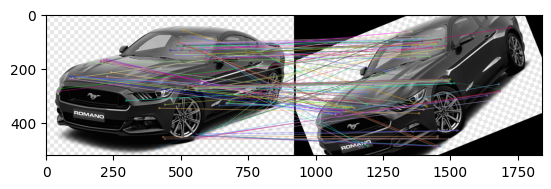

In [17]:
validate_matches(original_image, kp1, distorted_image, kp2, matches, file_name=image_path + '_matches.png')

In [18]:
def hamming(des1, des2):
    return bin(int.from_bytes(des1, byteorder='big') ^ int.from_bytes(des2, byteorder='big')).count('1')


def custom_matcher(des1, des2, threshold=25):
    matches = []

    for i, des1 in enumerate(des1):
        best_distance = float('inf')
        best_match_idx = None

        for j, descriptor2 in enumerate(des2):
            distance = hamming(des1, des2)
            if distance < best_distance:
                best_distance = distance
                best_match_idx = j

        if best_distance <= threshold:
            matches.append((i, best_match_idx, best_distance))

    return list(map(lambda match: DMatch(match[0], match[1], match[2]), matches))

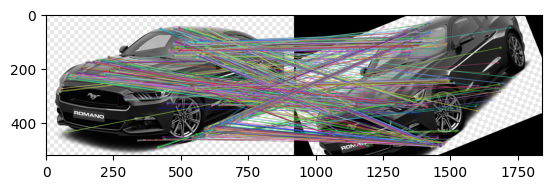

In [20]:
matches_own = custom_matcher(des1, des2, threshold=15)
validate_matches(original_image, kp1, distorted_image, kp2, matches_own, file_name=image_path + '_matches2.png')